In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.toy_data import *
from src.abstain import *

import sklearn
import pandas as pd

from operator import xor
from collections import defaultdict


# 2D Regret Data generation

In [2]:
#Define instances - true label pairs ie: (0,1,0) means instance x1=0 x2=1 has y=0
#(x1,x2,y)
true_labels = [
    (0, 0, 0),
    (0, 1, 0),
    (1, 0, 0),
    (1, 1, 0),
    (0, 0, 1),
    (0, 1, 1),
    (1, 0, 1),
    (1, 1, 1)
    
  
]

# Set the number of instances for each (x1, x2, y) pair
instances_counts = {
    (0, 0, 0): 50,
    (0, 1, 0): 50,
    (1, 0, 0): 0,
    (1, 1, 0): 0,
    (0, 0, 1): 0,
    (0, 1, 1): 0,
    (1, 0, 1): 50,
    (1, 1, 1): 50
}

##DO NOT CHANGE
X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(true_labels)
##DO NOT CHANGE

# Verifying counts in dataset

In [3]:
##DO NOT CHANGE
unique_values, counts = np.unique([str(x) for x in X], return_counts=True)

# Verifying instance counts
for val, count in zip(unique_values, counts):
    print(f"Instance: {val}, Count: {count}")
    
unique_values, counts = np.unique([str(x) for x in y], return_counts=True)

# Verifying label counts
for val, count in zip(unique_values, counts):
    print(f"Label: {val}, Count: {count}")
##DO NOT CHANGE

Instance: [0 0], Count: 50
Instance: [0 1], Count: 50
Instance: [1 0], Count: 50
Instance: [1 1], Count: 50
Label: 0, Count: 100
Label: 1, Count: 100


# Define parameters

In [4]:
d = 2  # number of dimensions of X (so far only working for d=2)
m = 1000 #number of retrainings when running our procedure
n_draws = 10 #number of unique noise draws

##DO NOT CHANGE
max_iter = 10000 #max iterations to try when drawing noise draws or posterior draws when evaluating for typicality
noise_type = "class_conditional"
loss_type = "0-1"
##DO NOT CHANGE

# Visualize noise rates vs regret rates

In [5]:
#Plotting regret metrics across different noise rates
#Fixes noise for class 0 at 0.0%

##DO NOT CHANGE
metrics_dfs = []
instance_metrics_dfs = []
class_metrics_dfs = []

for noise_level in [0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.49]:
    if noise_type == "class_independent":
        _, T = generate_class_independent_noise(y, noise_level)  # Fixed noise draw
        toy_data_helper(d, X, y, noise_type, noise_level, T, n_draws, loss_type, 0.1, metrics_dfs, instance_metrics_dfs, class_metrics_dfs)
    elif noise_type == "class_conditional":
        fixed_classes = [0]
        fixed_noises = [0.0]

        for fixed_class in fixed_classes:
            for fixed_noise in fixed_noises:
                _, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
                toy_data_helper(d, X, y, noise_type, noise_level, T, n_draws, loss_type, 0.1, metrics_dfs, instance_metrics_dfs, class_metrics_dfs)

metrics_df = pd.concat(metrics_dfs)
instance_metrics_df = pd.concat(instance_metrics_dfs)
class_metrics_df = pd.concat(class_metrics_dfs)
##DO NOT CHANGE

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

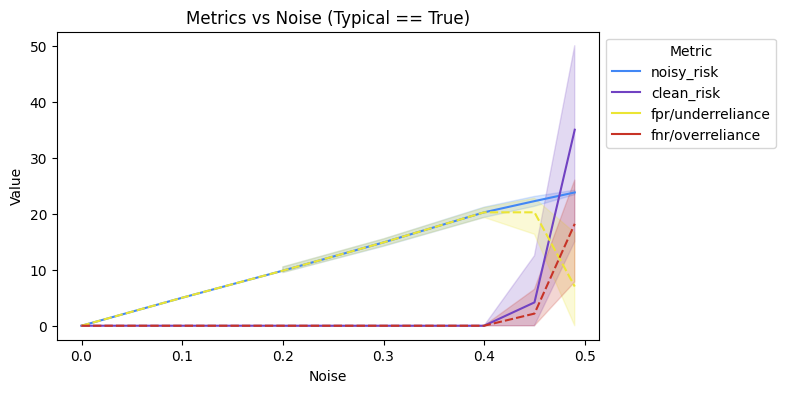

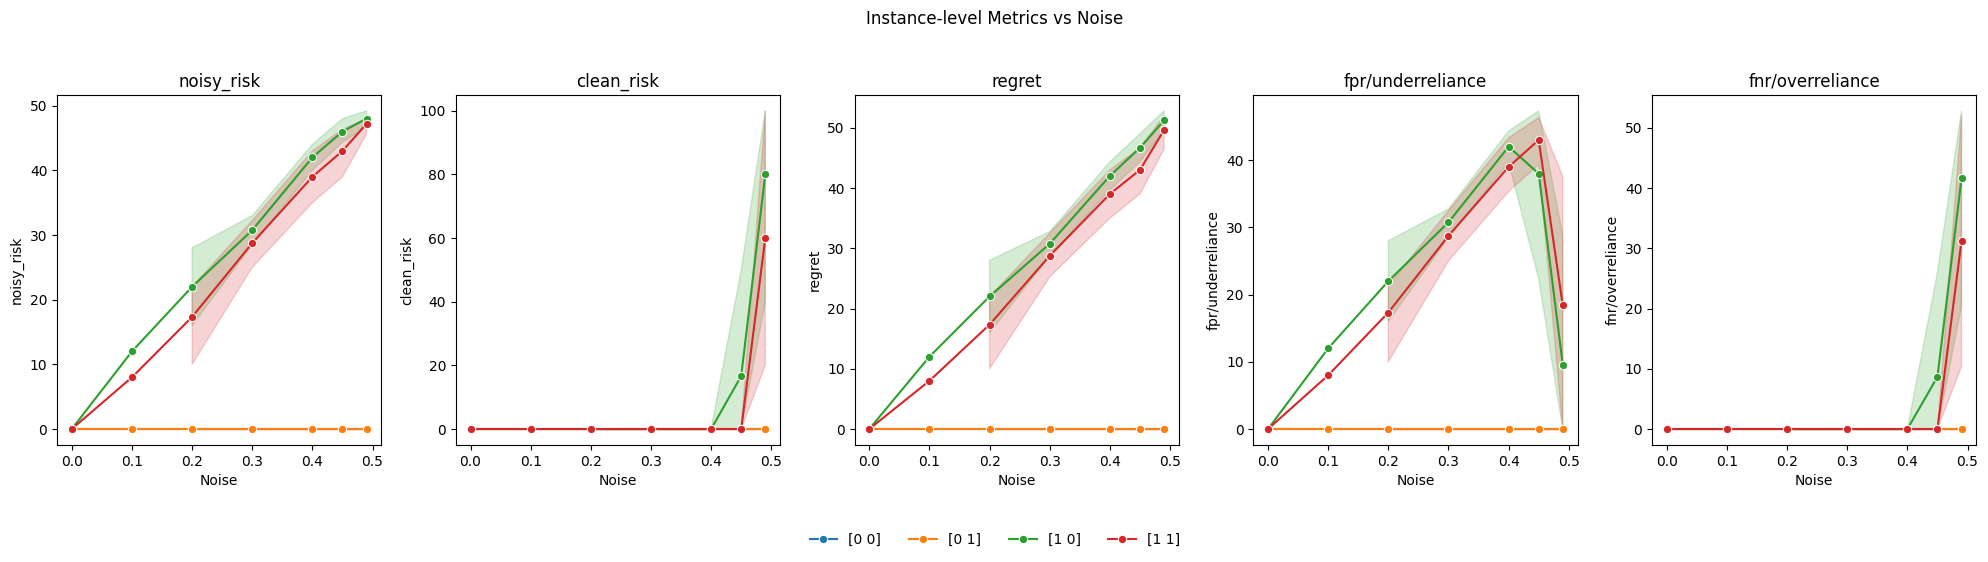

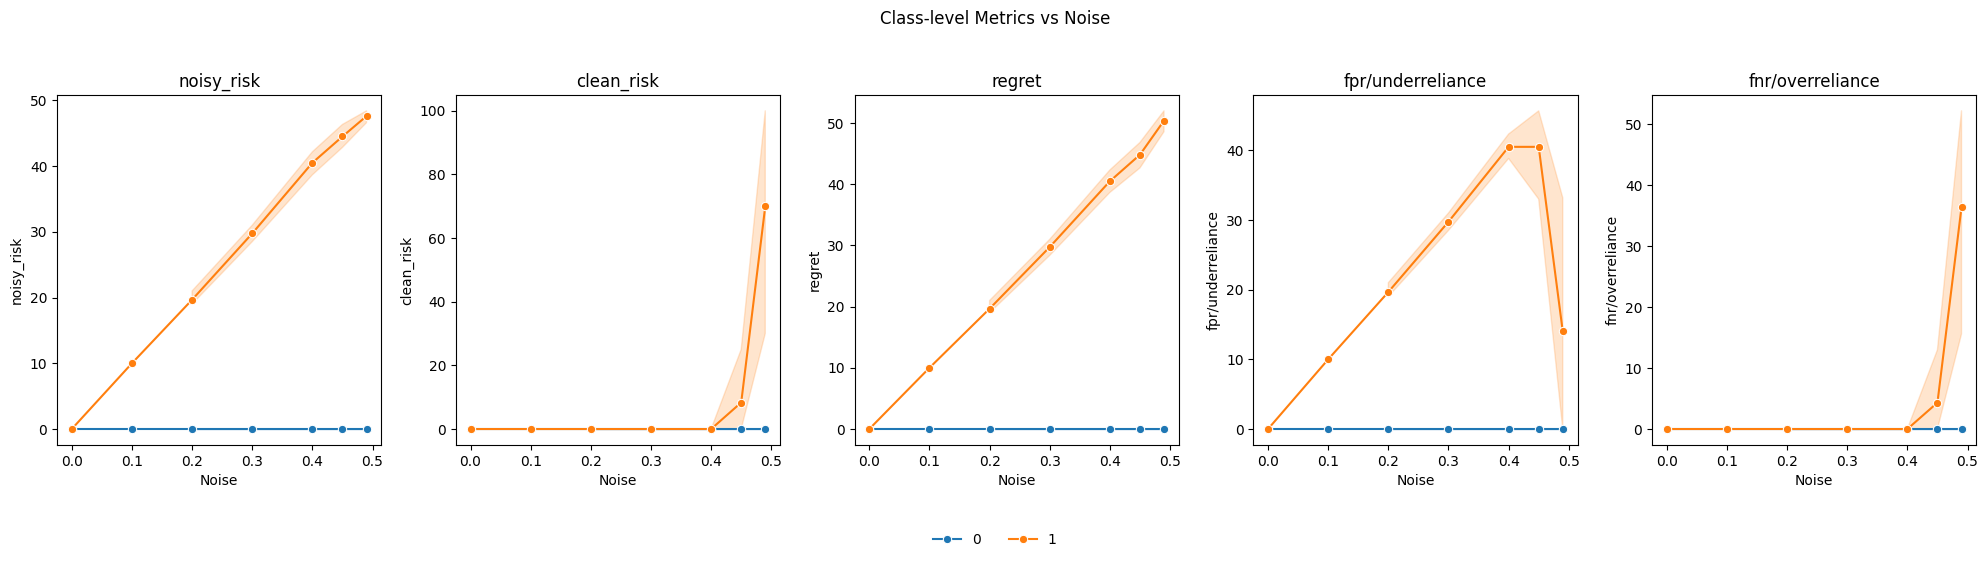

In [6]:
# Example usage
plot_regret_toy(metrics_df, instance_metrics_df, class_metrics_df)

# 2D Ambiguity/Abstain

In [46]:
from collections import Counter
import numpy as np

def run_procedure_toy(d, m, max_iter, X, yn, p_y_x_dict, group=None, noise_type="class_independent",
                      T=None, epsilon=0.10, misspecify=False):
    
    typical_count = 0
    preds_all = []
    errors = []
    
    y_vec = np.array(yn)  # Convert to NumPy array for efficiency

    # Efficiently count occurrences of 0 and 1 in yn
    yn_counts = {str(x): Counter() for x in X}
    for x, y in zip(X, y_vec):
        yn_counts[str(x)][y] += 1

    # Initialize yhat_counts to store cumulative counts across seeds
    yhat_counts = {str(x): {0: 0, 1: 0} for x in X}
    
    error_rate_counts = {str(x): {0: 0, 1: 0, 2:0} for x in X} ##key 2 is total

    for seed in range(1, max_iter + 1):
        # Infer u values
        u_vec = infer_u(y_vec, group=group, noise_type=noise_type, p_y_x_dict=p_y_x_dict, T=T, seed=seed)

        # Check if it is a "typical" run
        typical_flag, _ = is_typical(u_vec, p_y_x_dict, group=group, T=T, y_vec=y_vec,
                                     noise_type=noise_type, uncertainty_type="backward", epsilon=epsilon)
        
        if misspecify:
            typical_flag = True

        if not typical_flag:
            continue

        # Flip labels based on inferred u values
        flipped_labels = flip_labels(y_vec, u_vec)

#         # Efficiently count occurrences of 0 and 1 in flipped labels
#         for x, yhat in zip(X, flipped_labels):
#             yhat_counts[str(x)][yhat] += 1  

        # Train Bayesian model
        model, loss = bayes_model(d, X, flipped_labels, loss_type="0-1")
        
        # Get predictions
        preds = output_01(model, X)

        preds_all.append(preds)
        
        
        # Track total counts of each unique x across all iterations
        total_counts = {str(x): {0: 0, 1: 0} for x in X}  # Tracks occurrences of yp=0, yp=1

        for x, pred, yhat in zip(X, preds, flipped_labels):
            x_str = str(x)

            # Track sample average yp counts
            yhat_counts[x_str][yhat] += 1
            total_counts[x_str][yhat] += 1  # Track total occurrences of this yp at x

            # Compute n+ and n- based on fp(x) (Bayes model output)
            n_plus = 1 if pred == 0 and yhat != pred else 0  # Mistake when fp(x) = 0
            n_minus = 1 if pred == 1 and yhat != pred else 0  # Mistake when fp(x) = 1

            # Accumulate total mistakes, to be averaged later
            error_rate_counts[x_str][yhat] += n_plus + n_minus  # Store cumulative errors
            
            if pred != yhat:
                error_rate_counts[x_str][2] +=1

        # **Compute final error rates after all seeds** (normalize by total counts)
        for x_str in error_rate_counts:
            for yhat in [0, 1]:  # Normalize separately for yp=0 and yp=1
                if total_counts[x_str][yhat] > 0:  # Avoid division by zero
                    error_rate_counts[x_str][yhat] /= total_counts[x_str][yhat]
            error_rate_counts[x_str][2] /= total_counts[x_str][0] + total_counts[x_str][1]
        
        # Compute error
        errors.append(np.array(preds) != np.array(flipped_labels))
        typical_count += 1

        if typical_count == m:
            break  # Stop early if we reach the required typical runs

    # Compute the average frequency of yhat occurrences across all seeds
    for x_str in yhat_counts:
        yhat_counts[x_str][0] /= m
        yhat_counts[x_str][1] /= m
        error_rate_counts[x_str][0] /= m
        error_rate_counts[x_str][1] /= m
        
    

    #print(error_rate_counts)

    # Convert errors to NumPy for efficient calculations
    errors = np.array(errors)
    ambiguity = np.mean(errors, axis=0) * 100

    return ambiguity, yn_counts, yhat_counts, error_rate_counts



def abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=10, epsilon=0.1):
    """
    Generate a dictionary of ambiguity rates across a range of noise levels.
    
    :param noise_levels: A list or array of noise levels to test.
    :param X: The input features for the dataset.
    :param y: The true labels for the dataset.
    :param true_labels: The true labels dictionary for generating the dataset.
    :param instances_counts: The instances counts for generating the dataset.
    :return: A dictionary with keys as instances and values as lists of ambiguity rates.
    """
    
    group = np.repeat(0, len(y))
    
    p_y_x_dict = calculate_prior(y, group, noise_type=noise_type)  # Clean prior

    typical_count = 0
    preds_vec = []
    
    
    results = {
                "seed": [],
                "susceptible": [],
                "posterior": [],
              "ambiguity": [],
                "actual_error": [],
                "anticipated_error":[],
                "regret": [],
                "preds": [],
                  "yn": [],
                  "y": [],
                "X":[],
                "y_count":[],
                "yn_count":[],
                "yhat_count":[],
                "error_rate_count":[]}
    

    for seed in tqdm(range(1, n_draws*10+1)):
        u_vec = get_u(y, T=T, seed=seed, noise_type=noise_type)

        typical_flag, difference = is_typical(u_vec, p_y_x_dict,  T = T, y_vec = y, noise_type = noise_type, uncertainty_type = "forward", epsilon = epsilon)
        
        if typical_flag:    
            typical_count+=1
            
        else:
            continue
        
        yn = flip_labels(y, u_vec)
        
        posterior = calculate_posterior(yn, T, p_y_x_dict[0])
        results["posterior"].append(posterior)
        susceptible = np.sum(posterior > 0)/len(X)
        
        #TRAIN MODEL ON NOISY DATASET
        best_model_noisy, loss = bayes_model(d, X, yn, loss_type="0-1")
        preds = output_01(best_model_noisy, X)
    
        
        #COMPUTE REGRET METRICS
        error_noisy, err_anticipated = instance_01loss(yn, preds)
        error_clean, err_true = instance_01loss(y, preds)

        fp_vec = ((err_anticipated == 1) & (err_true == 0))
        fn_vec = ((err_anticipated == 0) & (err_true == 1))
        
        _, regret_vec = instance_01loss(err_anticipated, err_true)
        
        #RUN OUR PROCEDURE
        ambiguity, yn_counts, yhat_counts, error_rate_counts = run_procedure_toy(d, m, max_iter, X, yn, p_y_x_dict, group = group, noise_type = noise_type,  T = T, epsilon = epsilon)
        
        # Efficiently count occurrences of 0 and 1 in yn
        for x_i, y_i in zip(X,y):
            y_counts[str(x_i)][0] =0
            y_counts[str(x_i)][1] =0

        for x_i, y_i in zip(X, y):
            y_counts[str(x_i)][y_i] += 1


        results["seed"].append(seed) 
        results["susceptible"].append(susceptible)
        #results["disagreement"].append(disagreement)
        results["ambiguity"].append(ambiguity)
        results["actual_error"].append(err_true)
        results["anticipated_error"].append(err_anticipated)
        results["regret"].append(regret_vec)
        results["preds"].append(preds)
        results["yn"].append(yn)
        results["y"].append(y)
        results["X"].append(X) 
        results["y_count"].append(y_counts)
        results["yn_count"].append(yn_counts)
        results["yhat_count"].append(yhat_counts)  
        results["error_rate_count"].append(error_rate_counts)  
        
        if typical_count == n_draws:
            break
        
    metrics_df = pd.DataFrame(results)
    return metrics_df



In [69]:
d = 2  # number of dimensions of X (so far only working for d=2)
m = 10 #number of retrainings when running our procedure
n_draws = 5 #number of unique noise draws

##DO NOT CHANGE
max_iter = 1000 #max iterations to try when drawing noise draws or posterior draws when evaluating for typicality
noise_type = "class_conditional"
loss_type = "0-1"
##DO NOT CHANGE

noise_type = "class_conditional"
fixed_class = 0 #Class with no noise
fixed_noise = 0.0 #noise rate for class 0
noise_level = 0.1 #noise rate for class 1


#(x1,x2,y)
true_labels = [
    (0, 0, 0),
    (0, 1, 0),
    (1, 0, 0),
    (1, 1, 0),
    (0, 0, 1),
    (0, 1, 1),
    (1, 0, 1),
    (1, 1, 1)
    
  
]

# Set the number of instances for each (x1, x2, y) pair
instances_counts = {
    (0, 0, 0): 50,
    (0, 1, 0): 50,
    (1, 0, 0): 0,
    (1, 1, 0): 0,
    (0, 0, 1): 0,
    (0, 1, 1): 0,
    (1, 0, 1): 50,
    (1, 1, 1): 50
}


##DO NOT CHANGE
X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(true_labels)


_, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
##DO NOT CHANGE

  0%|          | 0/50 [00:00<?, ?it/s]

In [70]:
metrics_df

,seed,susceptible,posterior,ambiguity,actual_error,anticipated_error,regret,preds,yn,y,X,y_count,yn_count,yhat_count,error_rate_count
0,1,0.56,"[0.09090909090909091, 0.0, 0.0, 0.090909090909...","[10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[[0, 0], [1, 0], [1, 1], [0, 0], [1, 1], [0, 0...","{'[0 1]': {0: 50, 1: 0}, '[0 0]': {0: 50, 1: 0...","{'[0 0]': {0: 50}, '[1 0]': {1: 45, 0: 5}, '[1...","{'[0 0]': {0: 45.0, 1: 5.0}, '[1 0]': {0: 4.0,...","{'[0 0]': {0: 0.0, 1: 0.22057705026455027, 2: ..."
1,2,0.53,"[0.09090909090909091, 0.0, 0.0, 0.090909090909...","[10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[[0, 0], [1, 0], [1, 1], [0, 0], [1, 1], [0, 0...","{'[0 1]': {0: 50, 1: 0}, '[0 0]': {0: 50, 1: 0...","{'[0 0]': {0: 50}, '[1 0]': {1: 45, 0: 5}, '[1...","{'[0 0]': {0: 45.0, 1: 5.0}, '[1 0]': {0: 4.1,...","{'[0 0]': {0: 0.0, 1: 0.22057705026455027, 2: ..."
2,3,0.55,"[0.09090909090909091, 0.0, 0.0, 0.090909090909...","[10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[[0, 0], [1, 0], [1, 1], [0, 0], [1, 1], [0, 0...","{'[0 1]': {0: 50, 1: 0}, '[0 0]': {0: 50, 1: 0...","{'[0 0]': {0: 50}, '[1 0]': {1: 45, 0: 5}, '[1...","{'[0 0]': {0: 45.0, 1: 5.0}, '[1 0]': {0: 4.2,...","{'[0 0]': {0: 0.0, 1: 0.22057705026455027, 2: ..."
3,4,0.55,"[0.09090909090909091, 0.0, 0.09090909090909091...","[10.0, 0.0, 90.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[[0, 0], [1, 0], [1, 1], [0, 0], [1, 1], [0, 0...","{'[0 1]': {0: 50, 1: 0}, '[0 0]': {0: 50, 1: 0...","{'[0 0]': {0: 50}, '[1 0]': {1: 48, 0: 2}, '[1...","{'[0 0]': {0: 45.0, 1: 5.0}, '[1 0]': {0: 1.8,...","{'[0 0]': {0: 0.0, 1: 0.22057705026455027, 2: ..."
4,5,0.55,"[0.09090909090909091, 0.0, 0.0, 0.090909090909...","[10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[[0, 0], [1, 0], [1, 1], [0, 0], [1, 1], [0, 0...","{'[0 1]': {0: 50, 1: 0}, '[0 0]': {0: 50, 1: 0...","{'[0 0]': {0: 50}, '[1 0]': {1: 47, 0: 3}, '[1...","{'[0 0]': {0: 45.0, 1: 5.0}, '[1 0]': {0: 2.5,...","{'[0 0]': {0: 0.0, 1: 0.22057705026455027, 2: ..."


In [94]:
import numpy as np

# Convert to NumPy arrays
X = np.array(X)
yn = np.array(yn)
regret = np.array(regret)
ambiguity = np.array(ambiguity)
actual_error = np.array(actual_error)
anticipated_error = np.array(anticipated_error)

# Print results
print(aggregates)


{'regret': {'[0 0]': 0.0, '[0 1]': 0.0, '[1 0]': 0.06, '[1 1]': 0.14}, 'ambiguity': {'[0 0]': 0.1, '[0 1]': 0.07400000000000001, '[1 0]': 0.05, '[1 1]': 0.114}, 'actual_error': {'[0 0]': 0.0, '[0 1]': 0.0, '[1 0]': 0.0, '[1 1]': 0.0}, 'anticipated_error': {'[0 0]': 0.0, '[0 1]': 0.0, '[1 0]': 0.06, '[1 1]': 0.14}}


In [119]:
import pandas as pd
import numpy as np

# Creating a structured table
columns = ["seed", "X", "stat_name", "stat_value"]
simplified_df = pd.DataFrame(columns=columns)

for seed in metrics_df.seed.unique():
    metrics = metrics_df[metrics_df["seed"] == seed]
    X = metrics.X.values[0]

    # Extract relevant values
    preds = metrics.preds.values[0]
    yn = np.array(metrics.yn.values[0])  # Ensure NumPy array
    y = metrics.y.values[0]
    ambiguity = np.array(metrics.ambiguity.values[0]) / 100
    regret = np.array(metrics.regret.values[0])
    actual_error = np.array(metrics.actual_error.values[0])
    anticipated_error = np.array(metrics.anticipated_error.values[0])
    
    posterior = metrics.posterior.values[0]

    y_counts = metrics.y_count.values[0]
    yn_counts = metrics.yn_count.values[0]
    yhat_counts = metrics.yhat_count.values[0]
    error_rate_counts = metrics.error_rate_count.values[0]

    # Compute actual and anticipated error rates
    _, actual_error = instance_01loss(y, preds)
    _, anticipated_error = instance_01loss(yn, preds)
    _, regret = instance_01loss(anticipated_error, actual_error)

    # Get unique X values and corresponding indices
    unique_X, inverse_indices = np.unique(X, return_inverse=True, axis=0)

    # Mapping variable names to arrays
    metric_arrays = {
        "regret": regret,
        "ambiguity": ambiguity,
        "actual_error": actual_error,
        "anticipated_error": anticipated_error,
    }

    # Function to compute aggregate means per unique X
    def aggregate(values):
        return {str(x): np.mean(values[inverse_indices == i]) for i, x in enumerate(unique_X) if np.any(inverse_indices == i)}

    # Function to compute aggregates conditioned on yn = 0 or 1
    def aggregate_conditioned(values, yn, condition):
        return {
            str(x): np.mean(values[(inverse_indices == i) & (yn == condition)])
            for i, x in enumerate(unique_X)
            if np.any((inverse_indices == i) & (yn == condition))
        }

    # Compute aggregates
    aggregates = {key: aggregate(values) for key, values in metric_arrays.items()}

    # Compute conditioned aggregates
    aggregates_conditioned = {
        f"{key}_{cond}": aggregate_conditioned(values, yn, cond)
        for key, values in metric_arrays.items()
        for cond in [0, 1]
    }

    # Create dataframe entries
    data_entries = []
    for i, x in enumerate(X):
        str_x = str(x)  # Ensure consistent indexing

        # **1. Stuff the practitioner knows (X, yn counts)**
        data_entries.extend([
            {"seed": seed, "X": str_x, "stat_name": "Y=0_count", "stat_value": y_counts[str_x][0]},
            {"seed": seed, "X": str_x, "stat_name": "Y=1_count", "stat_value": y_counts[str_x][1]},
            {"seed": seed, "X": str_x, "stat_name": "Yn=0_count", "stat_value": yn_counts[str_x][0]},
            {"seed": seed, "X": str_x, "stat_name": "Yn=1_count", "stat_value": yn_counts[str_x][1]},
        ])

        # **2. Stuff to compute ambiguity (yp counts, error rates)**
        data_entries.extend([
            {"seed": seed, "X": str_x, "stat_name": "Yp=0_count", "stat_value": yhat_counts[str_x][0]},
            {"seed": seed, "X": str_x, "stat_name": "Yp=1_count", "stat_value": yhat_counts[str_x][1]},
            {"seed": seed, "X": str_x, "stat_name": "error_rate_Yp=0", "stat_value": error_rate_counts[str_x][0]},
            {"seed": seed, "X": str_x, "stat_name": "error_rate_Yp=1", "stat_value": error_rate_counts[str_x][1]},
            {"seed": seed, "X": str_x, "stat_name": "error_rate_Yp", "stat_value": error_rate_counts[str_x][2]},
        ])

        # **3. Stuff to evaluate impact (ambiguity, actual error, anticipated error)**
        for stat, values in metric_arrays.items():
            data_entries.append({"seed": seed, "X": str_x, "stat_name": stat, "stat_value": aggregates[stat].get(str_x, np.nan)})

        # **4. Conditioned first, then aggregate**
        for stat, values in aggregates_conditioned.items():
            data_entries.append({"seed": seed, "X": str_x, "stat_name": stat, "stat_value": values.get(str_x, np.nan)})

    # Append to the main DataFrame
    simplified_df = pd.concat([simplified_df, pd.DataFrame(data_entries)], ignore_index=True)

# Display the final DataFrame
print(simplified_df)
simplified_df.to_csv("2d_regret.csv")

      seed      X            stat_name  stat_value
0        1  [0 0]            Y=0_count        50.0
1        1  [0 0]            Y=1_count         0.0
2        1  [0 0]           Yn=0_count        50.0
3        1  [0 0]           Yn=1_count         0.0
4        1  [0 0]           Yp=0_count        45.0
...    ...    ...                  ...         ...
20995    5  [0 0]          ambiguity_1         NaN
20996    5  [0 0]       actual_error_0         0.0
20997    5  [0 0]       actual_error_1         NaN
20998    5  [0 0]  anticipated_error_0         0.0
20999    5  [0 0]  anticipated_error_1         NaN

[21000 rows x 4 columns]


/tmp/ipykernel_11854/2045148977.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  simplified_df = pd.concat([simplified_df, pd.DataFrame(data_entries)], ignore_index=True)


In [118]:
import pandas as pd

# Predefined column order
column_order = [
    "X",  
    # 1. Stuff the practitioner knows
    "Y=0_count", "Y=1_count", "Yn=0_count", "Yn=1_count",
    # 2. Stuff to compute ambiguity
    "Yp=0_count", "Yp=1_count", "error_rate_Yp=0", "error_rate_Yp=1", "error_rate_Yp",
    # 3. Stuff to evaluate impact (conditioned metrics first, then aggregate)
    "ambiguity_0", "ambiguity_1", "ambiguity",
    "actual_error_0", "actual_error_1", "actual_error",
    "anticipated_error_0", "anticipated_error_1", "anticipated_error",
    "regret_0", "regret_1", "regret"
]

# Pivot the table to create one row per unique X per seed, with stat names as columns
pivot_df = simplified_df.pivot_table(
    index=["seed", "X"], 
    columns="stat_name", 
    values="stat_value"
).reset_index()

# Reorder columns, keeping only those that exist in the DataFrame
existing_columns = [col for col in column_order if col in pivot_df.columns]
pivot_df = pivot_df[["seed"] + existing_columns]  # Ensure all needed columns are included

# Ensure full column display
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 100)  

# Print the table for each seed, dropping the "Seed" column
for seed in pivot_df["seed"].unique():
    print(f"\nseed: {seed}")
    print(pivot_df[pivot_df["seed"] == seed].drop(columns=["seed"]))


seed: 1
stat_name      X  Y=0_count  Y=1_count  Yn=0_count  Yn=1_count  Yp=0_count  Yp=1_count  \
0          [0 0]       50.0        0.0        50.0         0.0        45.0         5.0   
1          [0 1]       50.0        0.0        50.0         0.0        46.3         3.7   
2          [1 0]        0.0       50.0         5.0        45.0         4.0        46.0   
3          [1 1]        0.0       50.0         7.0        43.0         5.7        44.3   

stat_name  error_rate_Yp=0  error_rate_Yp=1  error_rate_Yp  ambiguity_0  ambiguity_1  ambiguity  \
0                 0.000000         0.220577       0.022825     0.100000          NaN      0.100   
1                 0.000000         0.132609       0.100856     0.074000          NaN      0.074   
2                 0.125329         0.000000       0.102033     0.800000          0.0      0.080   
3                 0.117144         0.000000       0.142449     0.814286          0.0      0.114   

stat_name  actual_error_0  actual_error_1  a

# Print table showing regret/ambiguity values for toy data

In [100]:
for seed in metrics_df.seed.unique():
    metrics = metrics_df[metrics_df["seed"] == seed]
    X = metrics.X.values[0]

    preds = metrics.preds.values[0]
    yn = metrics.yn.values[0]
    y = metrics.y.values[0]
    ambiguity = metrics.ambiguity.values[0]
    posterior = metrics.posterior.values[0] * 100

    print("Draw ID: ", seed)
    print("Susceptible Points %: ", metrics.susceptible.values[0] * 100)

    U = 1 * (y != yn)

    # Create DataFrame with existing points
    df = pd.DataFrame({
        "X": list(X),
        "y": y,
        "yn": yn,
        "U": U,
        "Ambiguity": ambiguity,
        "Posterior": posterior
    })

    # Convert X column to tuples for consistency
    df["X"] = df["X"].apply(tuple)

    # **Manually define missing cases (0,0) and (0,1) with U=1**
    missing_rows = pd.DataFrame([
        {"X": (0, 0), "y": 0, "yn": 0, "U": 1, "Ambiguity": 0, "Posterior": 0, "Count": 0},
        {"X": (0, 1), "y": 0, "yn": 0, "U": 1, "Ambiguity": 0, "Posterior": 0, "Count": 0},
    ])

    # **Append missing rows using `pd.concat()`**
    df = pd.concat([df, missing_rows], ignore_index=True)

    # Group by (X, y, yn, U) and compute aggregates
    grouped_df = df.groupby(["X", "y", "yn", "U"], as_index=False).agg(
        Count=("X", "size"),  # Proper count per (X, y, yn, U)
        Ambiguity_mean=("Ambiguity", "mean"),
        Posterior_mean=("Posterior", "mean")
    )

    print(grouped_df)
    print("\n")

    # Compute average ambiguity grouped by U (for regret analysis)
    grouped_df = df.groupby(["U"], as_index=False).agg({"Ambiguity": "mean"})
    print("Average Ambiguity by U value (ie: Regret): ")
    print(grouped_df)
    print("\n")

Draw ID:  1
Susceptible Points %:  56.00000000000001
        X  y  yn  U  Count  Ambiguity_mean  Posterior_mean
0  (0, 0)  0   0  0     50       10.000000        9.090909
1  (0, 0)  0   0  1      1        0.000000        0.000000
2  (0, 1)  0   0  0     50        7.400000        9.090909
3  (0, 1)  0   0  1      1        0.000000        0.000000
4  (1, 0)  1   0  1      5       80.000000        9.090909
5  (1, 0)  1   1  0     45        0.000000        0.000000
6  (1, 1)  1   0  1      7       81.428571        9.090909
7  (1, 1)  1   1  0     43        0.000000        0.000000


Average Ambiguity by U value (ie: Regret): 
   U  Ambiguity
0  0   4.627660
1  1  69.285714


Draw ID:  2
Susceptible Points %:  53.0
        X  y  yn  U  Count  Ambiguity_mean  Posterior_mean
0  (0, 0)  0   0  0     50            10.0        9.090909
1  (0, 0)  0   0  1      1             0.0        0.000000
2  (0, 1)  0   0  0     50             7.4        9.090909
3  (0, 1)  0   0  1      1             0.0  

# Visualizing abstention rate vs regret metrics at instance/class level

  0%|          | 0/50 [00:00<?, ?it/s]

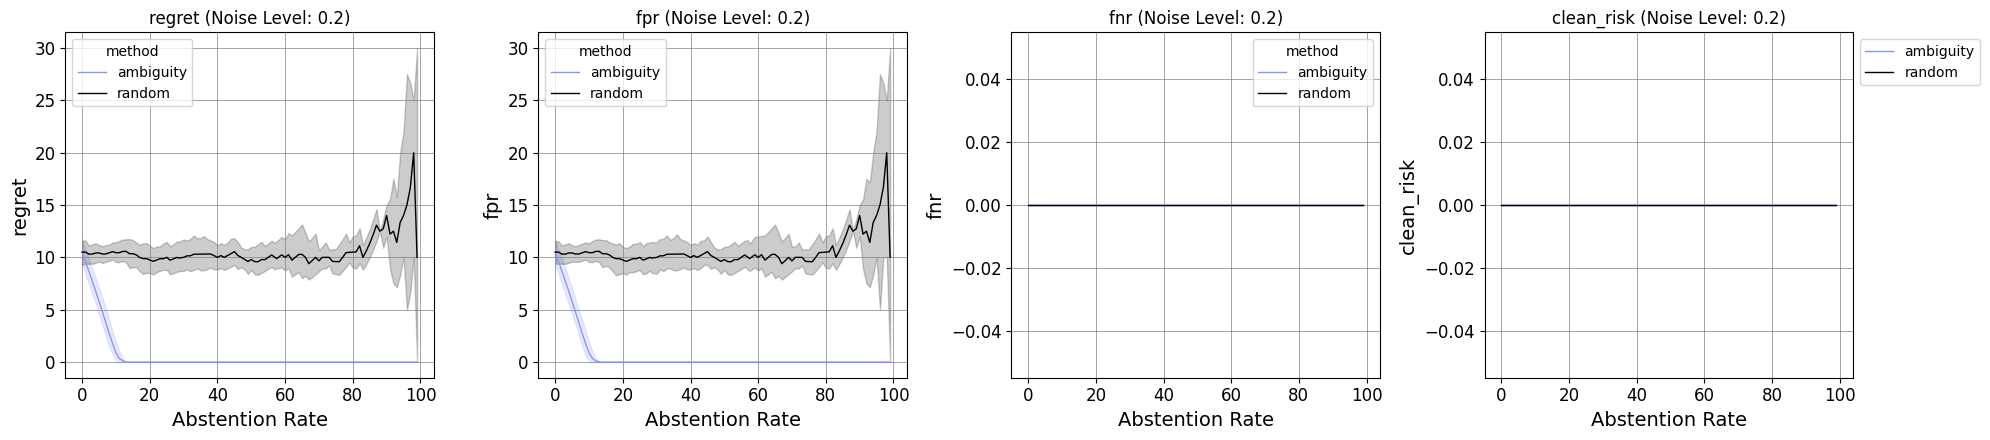

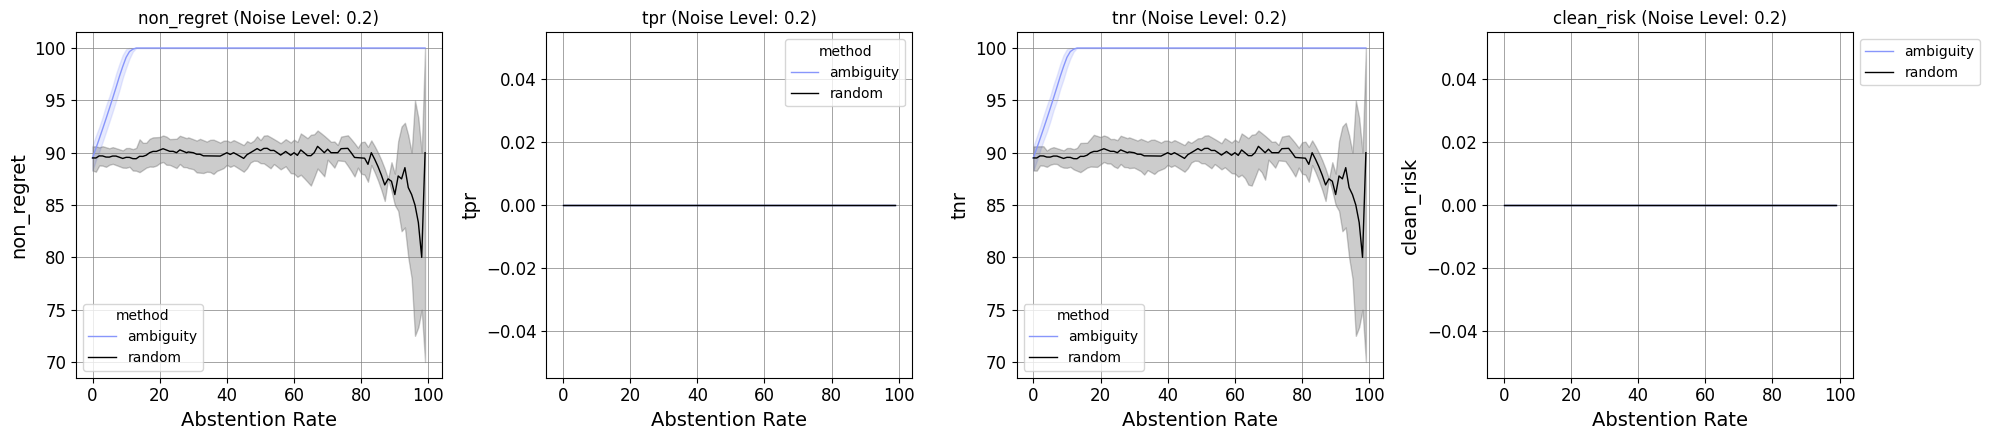

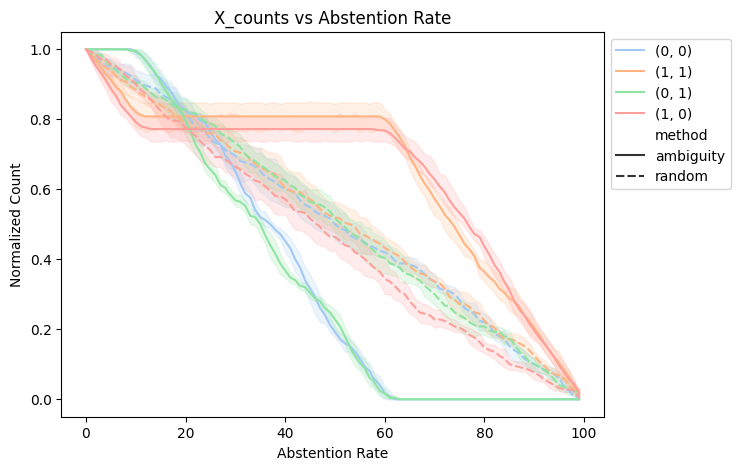

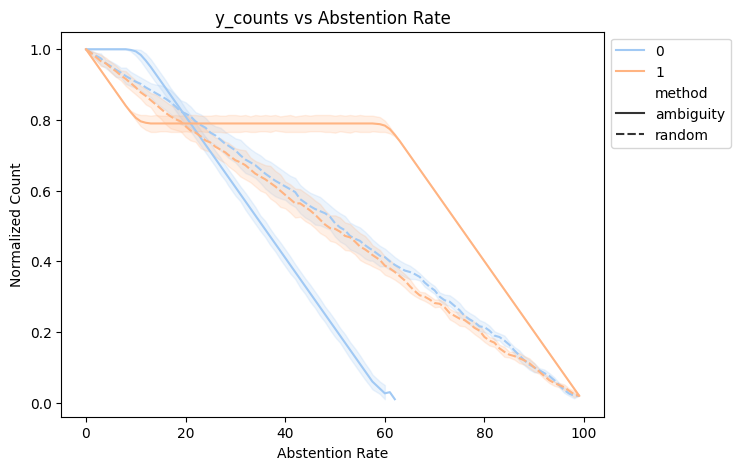

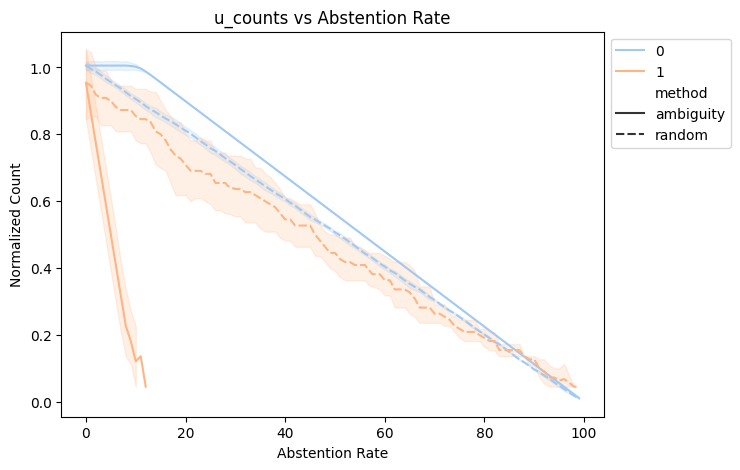

In [11]:
for noise_level in [0.2, 0.3, 0.35, 0.4][:1]:
    if noise_type == "class_independent":
        _, T = generate_class_independent_noise(y, noise_level)  # Fixed noise draw
        metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
        data = calculate_metrics_abstain_toy(metrics_df, noise_type=noise_type)
        plot_abstain_toy(data, noise_level)
    elif noise_type == "class_conditional":
        fixed_classes = [0]
        fixed_noises = [0.0]

        for fixed_class in fixed_classes:
            for fixed_noise in fixed_noises:
                _, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
                metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
                data = calculate_metrics_abstain_toy(metrics_df, noise_type=noise_type)
                plot_abstain_toy(data, noise_level)